In [1]:
%load_ext autoreload
%autoreload 2

from neural_circuits.LRRNN import get_W_eigs_np
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

import torch
torch.manual_seed(0)

import tensorflow as tf
from epi.models import Model, Parameter
from epi.util import get_max_H_dist
from neural_circuits.LRRNN import get_W_eigs_np, get_W_eigs_tf, get_simulator, \
                                  get_epi_times, get_snpe_times, \
                                  load_ME_EPI_LRRNN, load_best_SNPE_LRRNN, \
                                  SNPE_entropy, sim_r2RNN, \
                                  tf_num_params, torch_num_params, eig_scatter, \
                                  get_EPI_conv, get_SNPE_conv, get_SMC_conv
import pyabc
import warnings
warnings.filterwarnings('ignore')

"""RNN stable amplification."""

'RNN stable amplification.'

## Panel B

In [2]:
colors = sns.color_palette()

# SNPE setup
K = 1
num_sims = 1000
num_batch = 200
num_atoms = 100
x0 = np.array([0.5, 1.5])

# EPI setup
J_eig_realmax_mean = 0.5
Js_eig_max_mean = 1.5
eig_std = 0.25
mu = np.array([J_eig_realmax_mean,
               Js_eig_max_mean,
               eig_std**2,
               eig_std**2], dtype=np.float32)

In [3]:
SMC_conv = {}
SNPE_conv = {}
EPI_conv = {}
EPI_eps_conv = {}
Ns = [2, 5, 10, 25, 50, 100, 250]
eps = [0.25]
random_seeds = [1,2,3,4,5]
g = 0.01
for i, N in enumerate(Ns):
    for j, _eps in enumerate(eps):
       
        if j==0:
            smc_times, smc_sims = get_SMC_conv(N, random_seeds)
            SMC_conv.update({N:{'times':smc_times, 'sims':smc_sims}})

        if N < 50:
            _num_sims = num_sims
        elif N == 50:
            _num_sims = 25000
        elif N >= 100:
            _num_sims = 250000
            
        _num_batch = 1000 if N >= 100 else num_batch
        snpe_conv = get_SNPE_conv(N, g, K, x0, _eps,
                                          num_sims=_num_sims, 
                                          num_batch=_num_batch, 
                                          num_atoms=num_atoms,
                                          random_seeds=random_seeds)
        if snpe_conv[0] is not None:
            SNPE_conv.update({(N,_eps):{'times':snpe_conv[0], 'sims':snpe_conv[1]}})
        
        epi_conv = get_EPI_conv(N, g, K, random_seeds)
        if epi_conv[0] is not None:
            EPI_conv.update({(N,_eps):{'times':epi_conv[0], 'sims':epi_conv[1]}})
        epi_eps_conv = get_EPI_conv(N, g, K, random_seeds, _eps)
        if epi_eps_conv[0] is not None:
            EPI_eps_conv.update({(N,_eps):{'times':epi_eps_conv[0], 'sims':epi_eps_conv[1]}})

Processing SNPE N=2, g =0.01, rs=1.
Processing SNPE N=2, g =0.01, rs=2.
Processing SNPE N=2, g =0.01, rs=3.
Processing SNPE N=2, g =0.01, rs=4.
Processing SNPE N=2, g =0.01, rs=5.
Processing SNPE N=5, g =0.01, rs=1.
Processing SNPE N=5, g =0.01, rs=2.
Processing SNPE N=5, g =0.01, rs=3.
Processing SNPE N=5, g =0.01, rs=4.
Processing SNPE N=5, g =0.01, rs=5.
Processing SNPE N=10, g =0.01, rs=1.
Processing SNPE N=10, g =0.01, rs=2.
Processing SNPE N=10, g =0.01, rs=3.
Processing SNPE N=10, g =0.01, rs=4.
Processing SNPE N=10, g =0.01, rs=5.
Processing SNPE N=25, g =0.01, rs=1.
Processing SNPE N=25, g =0.01, rs=2.
Processing SNPE N=25, g =0.01, rs=3.
Processing SNPE N=25, g =0.01, rs=4.
Processing SNPE N=25, g =0.01, rs=5.
Processing SNPE N=50, g =0.01, rs=1.
Processing SNPE N=50, g =0.01, rs=2.
89 [42.22672131 42.35306301 42.36638002 42.56295696]
bad
Processing SNPE N=50, g =0.01, rs=3.
82 [58.16696861 58.36597357 58.43436743 58.69334794]
bad
Processing SNPE N=50, g =0.01, rs=4.
88 [45.0

[369.93379664 391.66617107 373.97672629 356.55104947 368.12738943]
[977.71788287]
[2419200. 2419200. 2419200. 2419200. 2419200.]


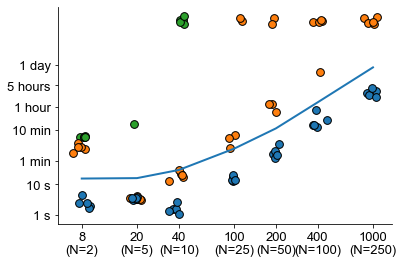

In [16]:
_eps = 0.25
epi_conv_means = [np.nanmean(EPI_conv[(N,_eps)]['times']) for N in Ns]
epi_conv_stds = [np.nanstd(EPI_conv[(N,_eps)]['times']) for N in Ns]
fontsize=15
scat_alpha = 1.

D_xticks = np.array([4*N for N in Ns])
xticks = np.log(Ns)
xtick_labels = ["%d\n(N=%d)" % (D,D//4) if ((D//4) in Ns) else ''
                for D in D_xticks]

yticks = np.log([1., 10., 60., 10*60., 60*60., 5*60*60., 24*60*60.])
ytick_labels = ["1 s", "10 s", "1 min", "10 min", "1 hour", "5 hours", "1 day"]

log_y_jit_std = 0.2

dotsize = 60
fig, ax = plt.subplots(1,1,figsize=(6,4))
nan_y = 4*7*24*60*60.
for N in Ns:
    smc_conv_times = SMC_conv[N]['times']
    if N==10 and len(smc_conv_times) == 0:
        smc_conv_times = 5*[np.nan]
    smc_y = np.array([val if not np.isnan(val) else nan_y for val in smc_conv_times])
    smc_log_jit_y = np.array([0. if not np.isnan(val) else np.random.normal(0., log_y_jit_std) 
                              for val in smc_conv_times])
    
    snpe_y = np.array([val if not np.isnan(val) else nan_y for val in SNPE_conv[(N, _eps)]['times']])
    snpe_log_jit_y = np.array([0. if not np.isnan(val) else np.random.normal(0., log_y_jit_std) 
                              for val in SNPE_conv[(N,_eps)]['times']])
    
    epi_y = np.array([val if not np.isnan(val) else nan_y for val in EPI_eps_conv[(N, _eps)]['times']])
    epi_log_jit_y = np.array([0. if not np.isnan(val) else np.random.normal(0., log_y_jit_std) 
                              for val in EPI_conv[(N,_eps)]['times']])
    
    if epi_y.shape[0] == 0:
        log_epi_y = np.nan*np.ones((len(epi_y)))
    else:
        assert(len(epi_y) == 5)
        log_epi_y = np.log(epi_y) + epi_log_jit_y
    if snpe_y.shape[0] == 0:
        log_snpe_y = np.nan*np.ones((len(snpe_y)))
    else:
        assert(len(snpe_y) == 5)
        log_snpe_y = np.log(snpe_y) + snpe_log_jit_y
    if smc_y.shape[0] == 0:
        log_smc_y = np.nan*np.ones((len(smc_y)))
    else:
        print(smc_y)
        #assert(len(smc_y) == 5)
        log_smc_y = np.log(smc_y) + smc_log_jit_y
        
    smc_log_jit = np.random.normal(0., 0.075, (len(smc_y),))
    snpe_log_jit = np.random.normal(0., 0.075, (len(snpe_y),))
    epi_log_jit = np.random.normal(0., 0.075, (len(epi_y),))
    
    ax.scatter(np.log(N)+smc_log_jit, log_smc_y, color=colors[2], 
               s=dotsize, edgecolor='k', alpha=scat_alpha)
    ax.scatter(np.log(N)+snpe_log_jit, log_snpe_y, color=colors[1], 
               s=dotsize, edgecolor='k', alpha=scat_alpha)
    ax.scatter(np.log(N)+epi_log_jit, log_epi_y, color=colors[0], 
               s=dotsize, edgecolor='k', alpha=scat_alpha)
    
ax.plot(np.log(np.array(Ns)), np.log(epi_conv_means), color=colors[0])
    
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels, fontname="Arial", fontsize=fontsize-2)
ax.set_yticks(yticks)
ax.set_yticklabels(ytick_labels, fontname="Arial", fontsize=fontsize-2)
plt.savefig(os.path.join("figures", "fig4", "converge_time.pdf"))
#ax.set_xlabel('parameter dimension (|z|)', fontname="Arial", fontsize=fontsize)
#ax.set_ylabel('time to convergence', fontname="Arial", fontsize=fontsize)

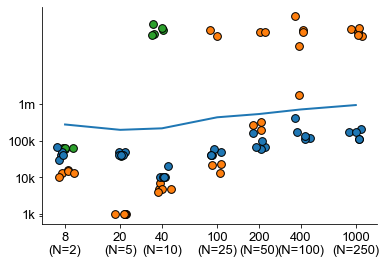

In [17]:
yticks = np.log10([900, 1e3, 1e4, 1e5, 1e6])
ytick_labels = ["", "1k", "10k", "100k", "1m"]

epi_conv_means = [np.nanmean(EPI_conv[(N,_eps)]['sims']) for N in Ns]
epi_conv_stds = [np.nanstd(EPI_conv[(N,_eps)]['sims']) for N in Ns]
                 
fig, ax = plt.subplots(1,1,figsize=(6,4))
nan_y = 1e8
for N in Ns:
    smc_conv_sims = SMC_conv[N]['sims']
    if N==10 and len(smc_conv_sims) == 0:
        smc_conv_sims = 5*[np.nan]
    smc_y = np.array([val if not np.isnan(val) else nan_y for val in smc_conv_sims])
    smc_log_jit_y = np.array([0. if not np.isnan(val) else np.random.normal(0., log_y_jit_std) 
                              for val in smc_conv_sims])
    
    snpe_y = np.array([val if not np.isnan(val) else nan_y for val in SNPE_conv[(N, _eps)]['sims']])
    snpe_log_jit_y = np.array([0. if not np.isnan(val) else np.random.normal(0., log_y_jit_std) 
                              for val in SNPE_conv[(N,_eps)]['sims']])
    
    epi_y = np.array([val if not np.isnan(val) else nan_y for val in EPI_eps_conv[(N, _eps)]['sims']])
    epi_log_jit_y = np.array([0. if not np.isnan(val) else np.random.normal(0., log_y_jit_std) 
                              for val in EPI_conv[(N,_eps)]['sims']])
    
    if epi_y.shape[0] == 0:
        log_epi_y = np.nan*np.ones((len(epi_y)))
    else:
        assert(len(epi_y) == 5)
        log_epi_y = np.log10(epi_y) + epi_log_jit_y
    if snpe_y.shape[0] == 0:
        log_snpe_y = np.nan*np.ones((len(snpe_y)))
    else:
        assert(len(snpe_y) == 5)
        log_snpe_y = np.log10(snpe_y) + snpe_log_jit_y
    if smc_y.shape[0] == 0:
        log_smc_y = np.nan*np.ones((len(smc_y)))
    else:
        #assert(len(smc_y) == 5)
        log_smc_y = np.log10(smc_y) + smc_log_jit_y
        
    smc_log_jit = np.random.normal(0., 0.075, (len(smc_y),))
    snpe_log_jit = np.random.normal(0., 0.075, (len(snpe_y),))
    epi_log_jit = np.random.normal(0., 0.075, (len(epi_y),))
    
    ax.scatter(np.log(N)+smc_log_jit, log_smc_y, color=colors[2], 
               s=dotsize, edgecolor='k', alpha=scat_alpha)
    ax.scatter(np.log(N)+snpe_log_jit, log_snpe_y, color=colors[1], 
               s=dotsize, edgecolor='k', alpha=scat_alpha)
    ax.scatter(np.log(N)+epi_log_jit, log_epi_y, color=colors[0], 
               s=dotsize, edgecolor='k', alpha=scat_alpha)
    
ax.plot(np.log(np.array(Ns)), np.log10(epi_conv_means), color=colors[0])


ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels, fontname="Arial", fontsize=fontsize-2)
ax.set_yticks(yticks)
ax.set_yticklabels(ytick_labels, fontname="Arial", fontsize=fontsize-2)

plt.savefig(os.path.join("figures", "fig4", "converge_sims.pdf"))
#ax.set_xlabel('parameter dimension (|z|)', fontname="Arial", fontsize=fontsize)
#ax.set_ylabel('# sims to convergence', fontname="Arial", fontsize=fontsize)

## Panel C

In [6]:
Ns = [2, 5, 10, 100, 250]
g = 0.01
num_Ns = len(Ns)
random_seeds = [1,2,3,4,5]

def load_SMC_samps(N, random_seeds):
    zs = []
    for _rs in random_seeds:
        base_path = os.path.join("data", "smc")
        save_dir = "SMC_RNN_stab_amp_N=%d_rs=%d" % (N, _rs)
        save_path = os.path.join(base_path, save_dir)

        try:
            with open(os.path.join(save_path, "optim.pkl"), "rb") as f:
                optim = pickle.load(f)
        except:
            continue
        zs.append(optim['z'])
    return zs
        
SMCs = {}
SNPE_max_val = {}
EPI_max_ent = {}
for i, N in enumerate(Ns):
    SMCs.update({N:{'zs':load_SMC_samps(N, random_seeds)}})
    
    if N < 50:
        _num_sims = num_sims
    elif N == 50:
        _num_sims = 25000
    elif N == 100:
        _num_sims = 250000

    _num_batch = 1000 if N == 100 else num_batch
    snpe_optim = load_best_SNPE_LRRNN(N, g, K, x0,
                                      num_sims=_num_sims, 
                                      num_batch=_num_batch, 
                                      num_atoms=num_atoms,
                                      random_seeds=random_seeds)
    if snpe_optim is not None:
        SNPE_max_val.update({N:snpe_optim})

    epi_optim = load_ME_EPI_LRRNN(N, g, K, mu, by_df=True)
    if epi_optim is not None:
        EPI_max_ent.update({N:epi_optim})

Processing SNPE N=2, g =0.01, rs=5.
Processing EPI: D=8, rs=1.
Processing EPI: D=8, rs=3.
Processing EPI: D=8, rs=4.
Processing EPI: D=8, rs=5.
Processing EPI: D=8, rs=2.

Processing SNPE N=5, g =0.01, rs=5.
Processing EPI: D=20, rs=1.
Processing EPI: D=20, rs=2.
Processing EPI: D=20, rs=5.
Processing EPI: D=20, rs=4.
Processing EPI: D=20, rs=3.

Processing SNPE N=10, g =0.01, rs=5.
Processing EPI: D=40, rs=5.
Processing EPI: D=40, rs=2.
Processing EPI: D=40, rs=3.
Processing EPI: D=40, rs=4.
Processing EPI: D=40, rs=1.

Processing SNPE N=100, g =0.01, rs=5.
Processing EPI: D=400, rs=1.
Processing EPI: D=400, rs=4.
Processing EPI: D=400, rs=3.
Processing EPI: D=400, rs=2.
Processing EPI: D=400, rs=5.

Error: no save path data/snpe/SNPE_RNN_stab_amp_N=250_sims=250000_batch=200_transforms=3_atoms=100_g=0.0100_K=1_rs=1.
Error: no save path data/snpe/SNPE_RNN_stab_amp_N=250_sims=250000_batch=200_transforms=3_atoms=100_g=0.0100_K=1_rs=2.
Error: no save path data/snpe/SNPE_RNN_stab_amp_N=250

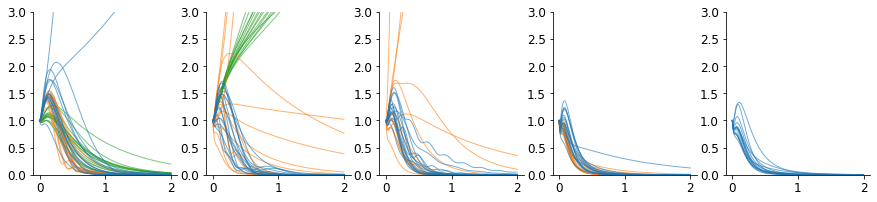

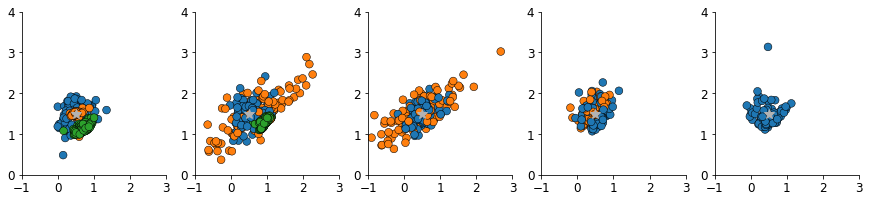

In [7]:
g = 0.01
plot_Ns = [2, 5, 10, 100, 250]
num_Ns = len(plot_Ns)
num_plot = 100
t = np.linspace(0,2,201)
n_traces = 15
fontsize = 12

all_T_xs = []
all_r_ts = []
all_colors = []
for i, N in enumerate(plot_Ns):
    T_xs = []
    r_ts = []
    _colors = []
    # SMC
    if N in SMCs:
        epi_optim = EPI_max_ent[N]
        model = epi_optim['model']
        zs = np.array(SMCs[N]['zs'])
        if len(zs):
            smc_zs = np.reshape(zs, (zs.shape[0]*zs.shape[1], zs.shape[2])).astype(np.float32)
            smc_T_x = model.eps(smc_zs)[:,:2]
            r_t_smc = sim_r2RNN(smc_zs, N, n_traces, t)
            T_xs.append(smc_T_x)
            _colors.append(colors[2])
            r_ts.append(r_t_smc)
        
    # SNPE
    if N in SNPE_max_val:
        snpe_optim = SNPE_max_val[N]
        round_val_log_probs = snpe_optim['round_val_log_probs']
        best_round = np.argmax(round_val_log_probs) + 1
        snpe_z = snpe_optim['zs'][best_round][:num_plot]
        snpe_T_x = snpe_optim['xs'][best_round][:num_plot]
        r_t_snpe = sim_r2RNN(snpe_z, N, n_traces, t)
        T_xs.append(snpe_T_x)
        _colors.append(colors[1])
        r_ts.append(r_t_snpe)
        
    # EPI
    if N in EPI_max_ent:
        epi_optim = EPI_max_ent[N]
        dist = epi_optim['dist']
        model = epi_optim['model']
        epi_z = dist(num_plot)
        epi_T_x = model.eps(epi_z)[:,:2]
        r_t_epi = sim_r2RNN(epi_z, N, n_traces, t)
        T_xs.append(epi_T_x)
        _colors.append(colors[0])
        r_ts.append(r_t_epi)
       
    T_xs.reverse()
    all_T_xs.append(T_xs)
    all_r_ts.append(r_ts)
    all_colors.append(_colors)
       
    
fig, axs = plt.subplots(1, num_Ns, figsize=(num_Ns*3, 3))
for i, N in enumerate(plot_Ns):
    r_ts = all_r_ts[i]
    _colors = all_colors[i]
    for j, r_t in enumerate(r_ts):
        axs[i].plot(t, r_t.T, c=_colors[j], lw=1., alpha=.6)
        axs[i].set_ylim([0,3])
plt.savefig(os.path.join("figures", "fig4", "T_x_simplots2.pdf"))
plt.show()
   
fig, axs = plt.subplots(1, num_Ns, figsize=(num_Ns*3, 3))
for i, N in enumerate(plot_Ns):
    T_xs = all_T_xs[i]
    _colors = all_colors[i]
    _colors.reverse()
    eig_scatter(T_xs, colors=_colors, ax=axs[i], perm=not(N==2))
plt.savefig(os.path.join("figures", "fig4", "T_x_simplots1.pdf"))
plt.show()
    


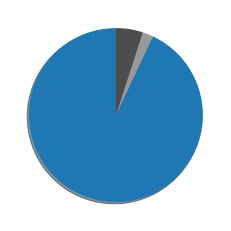

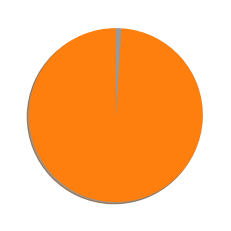

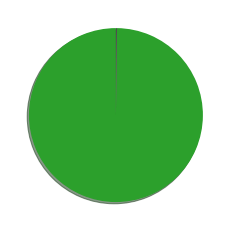

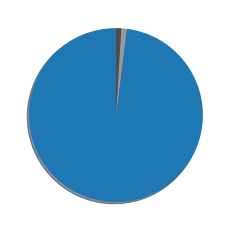

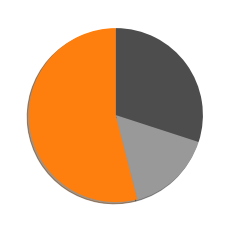

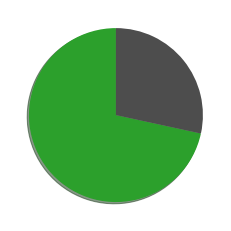

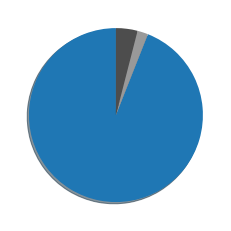

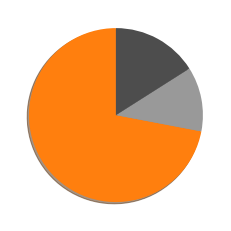

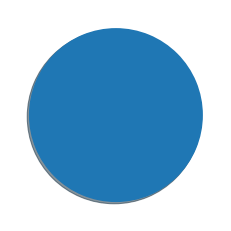

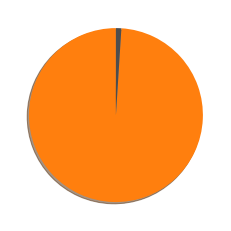

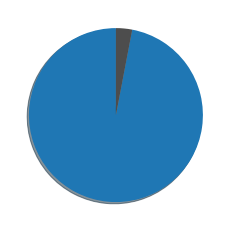

In [23]:
def regime_breakdown(T_x, c='k'):
    total = T_x.shape[0]
    num_stable_amp = np.sum(np.logical_and(T_x[:,0] < 1., T_x[:,1] > 1.))
    num_stable_mon = np.sum(np.logical_and(T_x[:,0] < 1., T_x[:,1] < 1.))
    num_unstable = np.sum(T_x[:,0] > 1.)
    sizes = [num_stable_amp, num_stable_mon, num_unstable]
    #labels = ['stable amplification', 'stable monotonic', 'unstable']
    explode = [0., 0., 0.]
    fig, ax = plt.subplots(1,1)
    ax.pie(sizes, colors=[c, 0.6*np.ones(3), 0.3*np.ones(3)], explode=explode, #labels=labels,
        shadow=True, startangle=90)

    return num_stable_amp, num_stable_mon, num_unstable

for i, N in enumerate(Ns):
    if N < 10:
        T_x_epi, T_x_snpe, T_x_smc = all_T_xs[i]
    elif N < 250:
        T_x_epi, T_x_snpe = all_T_xs[i]
    else:
        T_x_epi = all_T_xs[i][0]
       
    regime_breakdown(T_x_epi, colors[0])
    plt.savefig(os.path.join("figures", "fig4", "EPI_pie_N=%d" % N))
    plt.show()
    if N < 250:
        regime_breakdown(T_x_snpe, colors[1])
        plt.savefig(os.path.join("figures", "fig4", "SNPE_pie_N=%d" % N))
        plt.show()
    if N < 10:
        regime_breakdown(T_x_smc, colors[2])
        plt.savefig(os.path.join("figures", "fig4", "SMC_pie_N=%d" % N))
        plt.show()
